<a href="https://colab.research.google.com/github/ahenrij/arabic-digits-classification/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#About

This notebook is written in the context of the final exam's practical project for the Machine Learning course at ISTIC, University of Rennes 1.

We aim at classifying some arabic digits images using several machine learning models that we studied during the course.

__Author:__ Henri Aïdasso\
__Last update:__ 02-25-2022



# Setup

In [ ]:
import os
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
# mount drive and set current workdir
drive.mount('/content/drive')
cwd = '/content/drive/MyDrive/Colab Notebooks/FST'
datadir = cwd + '/data'
os.chdir(datadir)

Mounted at /content/drive


# Loading the datasets

In [ ]:
# Loading the main dataset and print it
dataset = pd.read_csv('./arabic_dataset.csv', delimiter=";", index_col=0)
dataset

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel1015,pixel1016,pixel1017,pixel1018,pixel1019,pixel1020,pixel1021,pixel1022,pixel1023,pixel1024
1,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1696,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1697,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1698,22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1699,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Loading the competition set and print it
competition = pd.read_csv('./competition.csv', delimiter=";", index_col=0)
competition.shape

(500, 1024)

500 examples represented with 1024 features columns to be predicted.

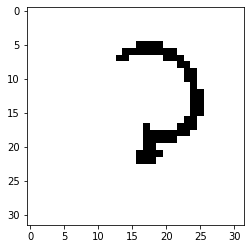

In [ ]:
# Here you can see the image 0 of the dataset
idx = 0
plt.imshow(dataset.iloc[idx,1:].to_numpy().reshape(32,32),cmap = 'Greys')
# you can change the value of idx if you want to see another image

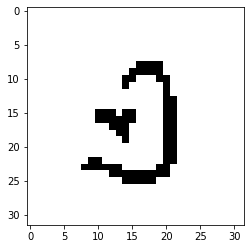

In [ ]:
# Same with the image 0 of competition
idx = 0
plt.imshow(competition.iloc[idx,:].to_numpy().reshape(32,32),cmap = 'Greys')

# Part 1 : Analysis of the dataset

Let display information an statistical describe of our dataset.

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1700 entries, 1 to 1700
Columns: 1025 entries, label to pixel1024
dtypes: int64(1025)
memory usage: 13.3 MB


We have 1700 entries and 1025 columns for each. Let's look at the statistical description of the columns.

In [ ]:
dataset.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel985,pixel986,pixel987,pixel988,pixel989,pixel990,pixel991,pixel992,pixel993,pixel994,pixel995,pixel996,pixel997,pixel998,pixel999,pixel1000,pixel1001,pixel1002,pixel1003,pixel1004,pixel1005,pixel1006,pixel1007,pixel1008,pixel1009,pixel1010,pixel1011,pixel1012,pixel1013,pixel1014,pixel1015,pixel1016,pixel1017,pixel1018,pixel1019,pixel1020,pixel1021,pixel1022,pixel1023,pixel1024
count,1700.000000,1700.0,1700.0,1700.0,1700.0,1700.0,1700.0,1700.0,1700.0,1700.0,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.0,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.0,1700.000000,1700.000000,1700.0,1700.0,1700.0,1700.0,1700.0,1700.0,1700.0,1700.0,...,1700.0,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.0,1700.0,1700.0,1700.000000,1700.0,1700.0,1700.0,1700.0,1700.0,1700.0,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.0,1700.000000,1700.0,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000
mean,11.017647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000588,0.000588,0.000588,0.000588,0.000588,0.0,0.000588,0.000588,0.001176,0.002941,0.002353,0.003529,0.002353,0.001176,0.001176,0.001176,0.001765,0.000588,0.001176,0.0,0.000588,0.000588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.002353,0.003529,0.001176,0.000588,0.000588,0.001765,0.001765,0.0,0.0,0.0,0.000588,0.0,0.0,0.0,0.0,0.0,0.0,0.000588,0.001176,0.001176,0.001765,0.001176,0.000588,0.002353,0.002353,0.002353,0.002941,0.002941,0.002353,0.0,0.001176,0.0,0.001765,0.002941,0.001176,0.000588,0.001176,0.002353,0.002353
std,7.550554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.024254,0.024254,0.024254,0.024254,0.024254,0.0,0.024254,0.024254,0.034290,0.054169,0.048464,0.059321,0.048464,0.034290,0.034290,0.034290,0.041984,0.024254,0.034290,0.0,0.024254,0.024254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.048464,0.059321,0.034290,0.024254,0.024254,0.041984,0.041984,0.0,0.0,0.0,0.024254,0.0,0.0,0.0,0.0,0.0,0.0,0.024254,0.034290,0.034290,0.041984,0.034290,0.024254,0.048464,0.048464,0.048464,0.054169,0.054169,0.048464,0.0,0.034290,0.0,0.041984,0.054169,0.034290,0.024254,0.034290,0.048464,0.048464
min,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

For each of the 1700 examples, we have 1024 numericals features describing each pixel of the 32x32 image with an integer scaled between 0 and 1. Let's see below the target values (label) distribution.


## Target

In [ ]:
dataset.label.value_counts()

12    255
6     250
22    245
18    241
1     238
2     238
16    233
Name: label, dtype: int64

The target variable is categorical and takes 7 possible values between: 1, 2, 6, 12, 16, 18, 22. We have a rather fair distribution in the dataset for each class as can be seen on the histogram below.

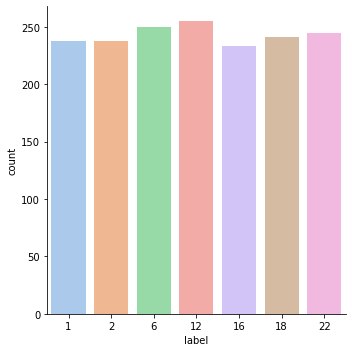

In [ ]:
sns.catplot(x="label", kind="count", palette="pastel", data=dataset)

**CLASSIFICATION TASK**

We therefore seek to make a multiclass classification of images. The explanatory variables are the integers describing the 1024 pixels of each 32x32 size image. The target variable is categorical with 7 possible values, each value corresponding to a specific letter of the Arabic alphabet.

## Data split

Before all, let's split our data into **training and testing sets**.
As we have a lot of hyperparameters tuning, we choose to use sklearn's **GridSearchCV for model selection** that makes use of **cross-validation** to have better confidence in our selections, or RandomizedSearchCV if there are too many parameters. On another hand, we'll make use of *random_state* everywhere for **reproducible outputs**.

We choose to take 80% of the data for training and cross-validation and the other 20% for testing purpose.

In [ ]:
y = dataset.label
X = dataset.drop('label', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [ ]:
print(f"Training Shape: X {X_train.shape} y {y_train.shape}")
print(f"Test Shape: X {X_test.shape} y {y_test.shape}")

Training Shape: X (1360, 1024) y (1360,)
Test Shape: X (340, 1024) y (340,)


# Part 2 : Classifiers based on raw images

In [ ]:
def model_accuracy(model, X_test, y_test):
  """Compute model accuracy on a test set and print it in percentage.

  Returns
  -------
    (float) accuracy: the model's accuracy score.
  """
  y_pred = model.predict(X_test)
  test_accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy  * 100))
  return test_accuracy

### Decision trees

First we instantiate a decision tree in order to compute its pruning path complexity.

In [ ]:
tree_model = DecisionTreeClassifier(random_state=7)
path = tree_model.cost_complexity_pruning_path(X_train, y_train)
print(f"{len(path.ccp_alphas)} different trees can be obtained")

284 different trees can be obtained


Now we search (thanks to GridSearchCV) between those possible pruning values, which one produces the best model in term of accuracy.

In [ ]:
# Search for best ccp_alpha param using GridSearchCV

grid = {"ccp_alpha": path.ccp_alphas} 
model = DecisionTreeClassifier(random_state=1)
grid_tree = GridSearchCV(model, grid, cv=5)
grid_tree.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1),
             param_grid={'ccp_alpha': array([0.        , 0.00067402, 0.00067402, 0.00070332, 0.00070466,
       0.00071232, 0.00072483, 0.00073529, 0.00073529, 0.00073529,
       0.00073529, 0.00073529, 0.00073529, 0.00073529, 0.00073529,
       0.00073529, 0.00073529, 0.00073529, 0.00073529, 0.00073529,
       0.00073529, 0.00073529, 0.00073529, 0.00073...
       0.00387215, 0.0039015 , 0.00398305, 0.00411422, 0.00434406,
       0.00464016, 0.00466224, 0.00473542, 0.00475264, 0.0048025 ,
       0.00509427, 0.00513407, 0.00520833, 0.00526274, 0.0053337 ,
       0.00554674, 0.00602522, 0.00614844, 0.00629481, 0.00638017,
       0.00698075, 0.00775018, 0.00790441, 0.00797262, 0.00850683,
       0.00870188, 0.00878563, 0.00987478, 0.01139617, 0.01180773,
       0.01284662, 0.01810079, 0.02344878, 0.02386087])})

The best parameters along with its accuracy score are automatically selected by grid search and available in the following attributes.

In [ ]:
print("Best parameters: ", grid_tree.best_params_)
print("Accuracy :", grid_tree.best_score_)

Best parameters:  {'ccp_alpha': 0.0018382352941176475}
Accuracy : 0.5345588235294119


We can display the params/score table. We just show the first 10 parameters.

In [ ]:
p_table = pd.DataFrame(grid_tree.cv_results_).loc[:, ['param_ccp_alpha', 'mean_test_score']]
p_table.head(10)

,param_ccp_alpha,mean_test_score
0,0.0,0.530882
1,0.000674,0.530882
2,0.000674,0.530882
3,0.000703,0.530882
4,0.000705,0.530882
5,0.000712,0.530882
6,0.000725,0.530882
7,0.000735,0.530882
8,0.000735,0.530882
9,0.000735,0.530882


And visually check the result.

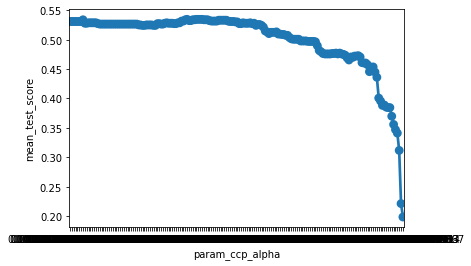

In [ ]:
sns.pointplot(data=p_table, x='param_ccp_alpha', y='mean_test_score')

We can see that the max score is near 0.55 

**Generalization accuracy**

In [ ]:
score_tree = model_accuracy(grid_tree, X_test, y_test)

Accuracy for our testing dataset with tuning is : 56.47%


In the following sections, the structure of training a model will be quite the same. We will comment only on particular points such as comparing models' generalization accuracy. All the submissions are made in the bottom section dedicated to it to avoid redundancy.

### SVM

#### Linear SVM

In [ ]:
# Search for best params using GridSearchCV

grid_params = {'C': [0.005, 0.01, 0.05, 0.1, 1, 10, 100], 'kernel': ['linear']}
model = SVC(random_state=1)
grid_linear_svm = GridSearchCV(model, grid_params, refit=True, verbose=0, cv=5)
grid_linear_svm.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=1),
             param_grid={'C': [0.005, 0.01, 0.05, 0.1, 1, 10, 100],
                         'kernel': ['linear']})

In [ ]:
print("Best parameters: ", grid_linear_svm.best_params_) 
print("Accuracy: {:.2%}".format(grid_linear_svm.best_score_))

Best parameters:  {'C': 0.01, 'kernel': 'linear'}
Accuracy: 70.74%


Params comparison table

In [ ]:
p_table = pd.DataFrame(grid_linear_svm.cv_results_).loc[:, ['params', 'mean_test_score']]
p_table

,params,mean_test_score
0,"{'C': 0.005, 'kernel': 'linear'}",0.681618
1,"{'C': 0.01, 'kernel': 'linear'}",0.707353
2,"{'C': 0.05, 'kernel': 'linear'}",0.702941
3,"{'C': 0.1, 'kernel': 'linear'}",0.688235
4,"{'C': 1, 'kernel': 'linear'}",0.669118
5,"{'C': 10, 'kernel': 'linear'}",0.669118
6,"{'C': 100, 'kernel': 'linear'}",0.669118


**Generalization accuracy**

In [ ]:
score_linear_svm = model_accuracy(grid_linear_svm, X_test, y_test)

Accuracy for our testing dataset with tuning is : 72.94%


Models comparison table

In [ ]:
m_table = pd.DataFrame(index=['Tree', 'Linear SVC'])
m_table['Gen. Score'] = [score_tree, score_linear_svm]
m_table['Gen. Score'] = m_table['Gen. Score'].apply(lambda row: "{:.2%}".format(row))
m_table

,Gen. Score
Tree,56.47%
Linear SVC,72.94%


The linear support vectors classifier will certainly perform better than the decision tree model with a much higher accuracy.

#### Polynomial SVM

In [ ]:
# Search for best ccp_alpha param using GridSearchCV

grid_params = {'C': [0.005, 0.01, 0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['poly']}
model = SVC(random_state=1)
grid_poly_svm = GridSearchCV(model, grid_params, refit=True, verbose=0, cv=5)
grid_poly_svm.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=1),
             param_grid={'C': [0.005, 0.01, 0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['poly']})

In [ ]:
print("Best parameters: ", grid_poly_svm.best_params_) 
print("Accuracy: {:.2%}".format(grid_poly_svm.best_score_))

Best parameters:  {'C': 0.005, 'gamma': 1, 'kernel': 'poly'}
Accuracy: 74.26%


Params comparison table

In [ ]:
p_table = pd.DataFrame(grid_poly_svm.cv_results_).loc[:, ['params', 'mean_test_score']]
p_table.head(10)

,params,mean_test_score
0,"{'C': 0.005, 'gamma': 1, 'kernel': 'poly'}",0.742647
1,"{'C': 0.005, 'gamma': 0.1, 'kernel': 'poly'}",0.663235
2,"{'C': 0.005, 'gamma': 0.01, 'kernel': 'poly'}",0.153676
3,"{'C': 0.005, 'gamma': 0.001, 'kernel': 'poly'}",0.153676
4,"{'C': 0.01, 'gamma': 1, 'kernel': 'poly'}",0.742647
5,"{'C': 0.01, 'gamma': 0.1, 'kernel': 'poly'}",0.718382
6,"{'C': 0.01, 'gamma': 0.01, 'kernel': 'poly'}",0.153676
7,"{'C': 0.01, 'gamma': 0.001, 'kernel': 'poly'}",0.153676
8,"{'C': 0.1, 'gamma': 1, 'kernel': 'poly'}",0.742647
9,"{'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}",0.741912


We already know which one is the best parameters, we don't really need to visually see it.

In [ ]:
score_poly_svm = model_accuracy(grid_poly_svm, X_test, y_test)

Accuracy for our testing dataset with tuning is : 77.94%


Models comparison

In [ ]:
m_table = pd.DataFrame(index=['Tree', 'Linear SVC', 'Poly SVC'])
m_table['Gen. Score'] = [score_tree, score_linear_svm, score_poly_svm]
m_table['Gen. Score'] = m_table['Gen. Score'].apply(lambda row: "{:.2%}".format(row))
m_table

,Gen. Score
Tree,56.47%
Linear SVC,72.94%
Poly SVC,77.94%


We can see here that the polynomial SVC performs better than the linear one which was the best.

#### RBF SVC

In [ ]:
# Search for best ccp_alpha param using GridSearchCV

grid_params = {'C': [0.005, 0.01, 0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']}
model = SVC(random_state=1)
grid_rbf_svm = GridSearchCV(model, grid_params, refit=True, verbose=0, cv=5)
grid_rbf_svm.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=1),
             param_grid={'C': [0.005, 0.01, 0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']})

In [ ]:
print("Tuned hyperparameters (best parameters): ", grid_rbf_svm.best_params_) 
print("Accuracy: {:.2%}".format(grid_rbf_svm.best_score_))

Tuned hyperparameters (best parameters):  {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Accuracy: 77.50%


Params comparison table

In [ ]:
p_table = pd.DataFrame(grid_rbf_svm.cv_results_).loc[:, ['params', 'mean_test_score']]
p_table

,params,mean_test_score
0,"{'C': 0.005, 'gamma': 1, 'kernel': 'rbf'}",0.153676
1,"{'C': 0.005, 'gamma': 0.1, 'kernel': 'rbf'}",0.153676
2,"{'C': 0.005, 'gamma': 0.01, 'kernel': 'rbf'}",0.153676
3,"{'C': 0.005, 'gamma': 0.001, 'kernel': 'rbf'}",0.153676
4,"{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}",0.153676
5,"{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}",0.153676
6,"{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}",0.153676
7,"{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}",0.153676
8,"{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}",0.153676
9,"{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}",0.153676


In [ ]:
score_rbf_svm = model_accuracy(grid_rbf_svm, X_test, y_test)

Accuracy for our testing dataset with tuning is : 81.47%


Models comparison table

In [ ]:
m_table = pd.DataFrame(index=['Arbre', 'Linear SVC', 'Poly SVC', 'RBF SVC'])
m_table['Gen. Score'] = [score_tree, score_linear_svm, score_poly_svm, score_rbf_svm]
m_table['Gen. Score'] = m_table['Gen. Score'].apply(lambda row: "{:.2%}".format(row))
m_table

,Gen. Score
Arbre,56.47%
Linear SVC,72.94%
Poly SVC,77.94%
RBF SVC,81.47%


As we can, we now have again a better with the radial basis function kernel of SVC.

### K-nearest-neighbour

In [ ]:
# Search for best k param using GridSearchCV

grid_params = {"n_neighbors": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 30, 50]} 
model = KNeighborsClassifier()
grid_knn = GridSearchCV(model, grid_params, refit=True, verbose=0, cv=5)
grid_knn.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 30,
                                         50]})

In [ ]:
print("Best parameters: ", grid_knn.best_params_) 
print("Accuracy: {:.2%}".format(grid_knn.best_score_))

Best parameters:  {'n_neighbors': 1}
Accuracy: 71.40%


Params comparison

In [ ]:
p_table = pd.DataFrame(grid_knn.cv_results_).loc[:, ['params', 'mean_test_score']]
p_table

,params,mean_test_score
0,{'n_neighbors': 1},0.713971
1,{'n_neighbors': 2},0.621324
2,{'n_neighbors': 3},0.658088
3,{'n_neighbors': 4},0.641176
4,{'n_neighbors': 5},0.641912
5,{'n_neighbors': 6},0.638235
6,{'n_neighbors': 7},0.630147
7,{'n_neighbors': 8},0.613235
8,{'n_neighbors': 9},0.613971
9,{'n_neighbors': 10},0.597059


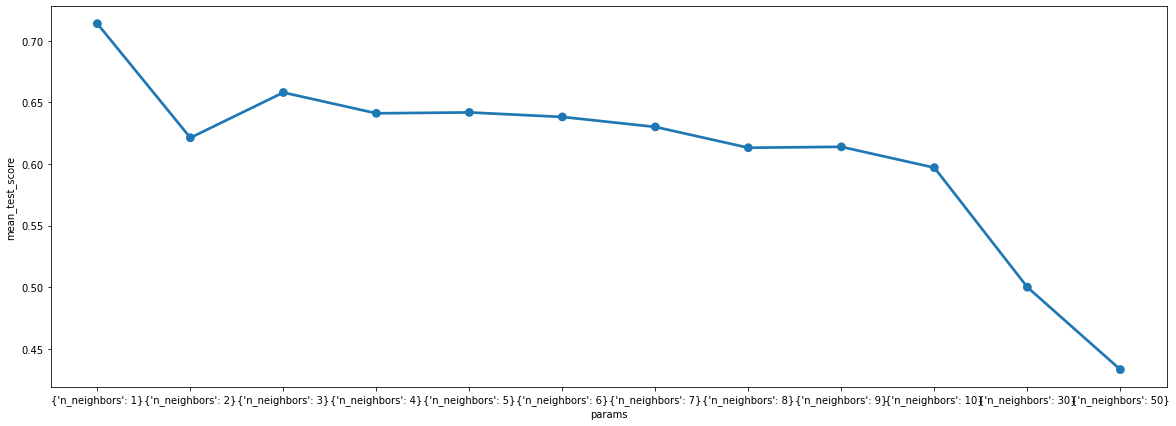

In [ ]:
p_table['params'] = p_table['params'].astype(str)
plt.figure(figsize=(20, 7))
sns.pointplot(data=p_table, x='params', y='mean_test_score')

Visually, the higher the number of neighbors, generally the lower the cross validation accuracy.

In [ ]:
score_knn = model_accuracy(grid_knn, X_test, y_test)

Accuracy for our testing dataset with tuning is : 75.59%


Models comparison

In [ ]:
m_table = pd.DataFrame(index=['Arbre', 'Linear SVC', 'Poly SVC', 'RBF SVC', 'KNN'])
m_table['Gen. Score'] = [score_tree, score_linear_svm, score_poly_svm, score_rbf_svm, score_knn]
m_table['Gen. Score'] = m_table['Gen. Score'].apply(lambda row: "{:.2%}".format(row))
m_table

,Gen. Score
Arbre,56.47%
Linear SVC,72.94%
Poly SVC,77.94%
RBF SVC,81.47%
KNN,75.59%


The KNN model seems not to be that good when compared to the RBF SVC which is still the best model so far.

### Random forest

This model is way more time consuming as it aggrege multiple forest results. To search faster, let's use a 3-fold cross validation and try randomly 10 differents parameters' combination.

In [ ]:
# number of trees
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)]

# maximum depth of each tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] # 12
max_depth.append(None)

# 240 combinations possibles.
grid_params = {'n_estimators': n_estimators, 'max_depth': max_depth,}
model = RandomForestClassifier(random_state=0)
grid_rf = RandomizedSearchCV(model, grid_params, refit=True, verbose=2, cv=3, n_iter=10)
grid_rf.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ..................max_depth=None, n_estimators=1600; total time=   5.8s
[CV] END ..................max_depth=None, n_estimators=1600; total time=   5.8s
[CV] END ..................max_depth=None, n_estimators=1600; total time=   5.8s
[CV] END .....................max_depth=70, n_estimators=100; total time=   0.4s
[CV] END .....................max_depth=70, n_estimators=100; total time=   0.4s
[CV] END .....................max_depth=70, n_estimators=100; total time=   0.4s
[CV] END ....................max_depth=100, n_estimators=900; total time=   3.3s
[CV] END ....................max_depth=100, n_estimators=900; total time=   3.3s
[CV] END ....................max_depth=100, n_estimators=900; total time=   3.2s
[CV] END .....................max_depth=90, n_estimators=700; total time=   2.7s
[CV] END .....................max_depth=90, n_estimators=700; total time=   2.5s
[CV] END .....................max_depth=90, n_es

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0),
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100, 1200,
                                                         1300, 1400, 1500, 1600,
                                                         1700, 1800, 1900,
                                                         2000]},
                   verbose=2)

Let's visually see what tendancy we get in the results.

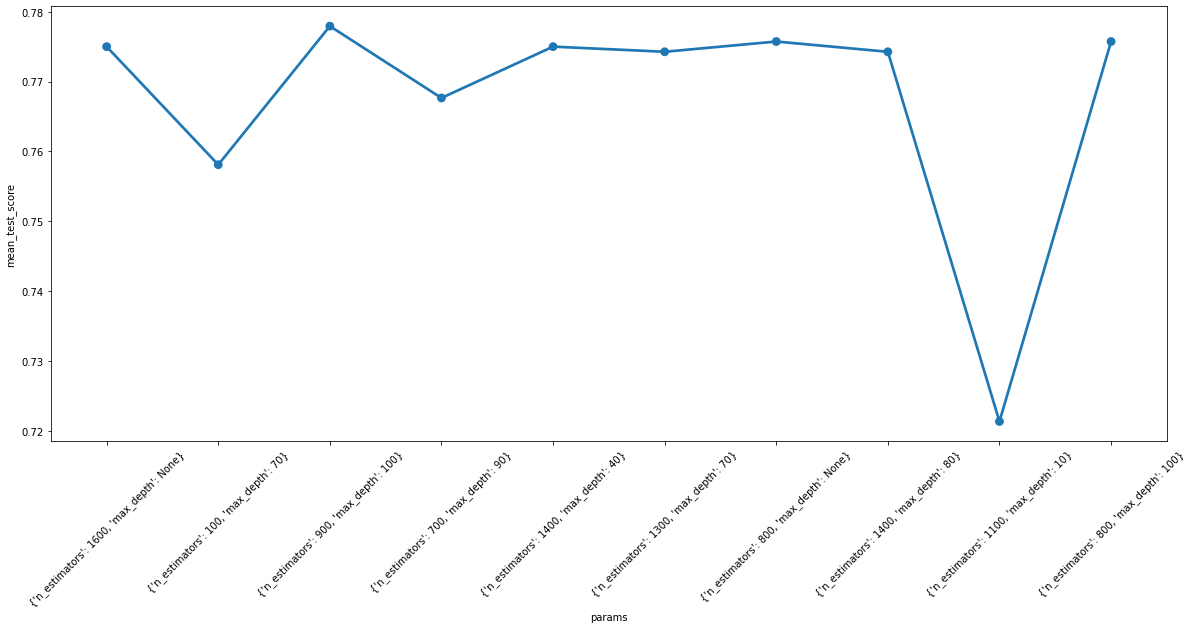

In [ ]:
p_table = pd.DataFrame(grid_rf.cv_results_).loc[:, ['params', 'mean_test_score']]
p_table['params'] = p_table['params'].astype(str)

#plot
plt.figure(figsize=(20, 8))
plt.xticks(rotation=45)
sns.pointplot(data=p_table, x='params', y='mean_test_score')

It seems that we have better accuracy with big number of trees and high max_depth.

The result of random cv search helped us restrain value to followings

In [ ]:

grid_params = {'n_estimators': [900, 1000, 1200, 1400, 2000], 'max_depth': [50, 60, 100, None],}
grid_rf = GridSearchCV(model, grid_params, refit=True, verbose=2, cv=3)
grid_rf.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END .....................max_depth=50, n_estimators=900; total time=   3.4s
[CV] END .....................max_depth=50, n_estimators=900; total time=   3.3s
[CV] END .....................max_depth=50, n_estimators=900; total time=   3.3s
[CV] END ....................max_depth=50, n_estimators=1000; total time=   5.2s
[CV] END ....................max_depth=50, n_estimators=1000; total time=   5.0s
[CV] END ....................max_depth=50, n_estimators=1000; total time=   5.5s
[CV] END ....................max_depth=50, n_estimators=1200; total time=   8.1s
[CV] END ....................max_depth=50, n_estimators=1200; total time=   7.2s
[CV] END ....................max_depth=50, n_estimators=1200; total time=   4.4s
[CV] END ....................max_depth=50, n_estimators=1400; total time=   7.2s
[CV] END ....................max_depth=50, n_estimators=1400; total time=   5.1s
[CV] END ....................max_depth=50, n_est

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [50, 60, 100, None],
                         'n_estimators': [900, 1000, 1200, 1400, 2000]},
             verbose=2)

In [ ]:
print("Best parameters: ", grid_rf.best_params_) 
print("Accuracy: {:.2%}".format(grid_rf.best_score_))

Best parameters:  {'max_depth': 50, 'n_estimators': 1200}
Accuracy: 77.79%


Params comparison

In [ ]:
p_table = pd.DataFrame(grid_rf.cv_results_).loc[:, ['params', 'mean_test_score']]
p_table

,params,mean_test_score
0,"{'max_depth': 50, 'n_estimators': 900}",0.777933
1,"{'max_depth': 50, 'n_estimators': 1000}",0.776462
2,"{'max_depth': 50, 'n_estimators': 1200}",0.777938
3,"{'max_depth': 50, 'n_estimators': 1400}",0.774259
4,"{'max_depth': 50, 'n_estimators': 2000}",0.772789
5,"{'max_depth': 60, 'n_estimators': 900}",0.777933
6,"{'max_depth': 60, 'n_estimators': 1000}",0.776462
7,"{'max_depth': 60, 'n_estimators': 1200}",0.777938
8,"{'max_depth': 60, 'n_estimators': 1400}",0.774259
9,"{'max_depth': 60, 'n_estimators': 2000}",0.772789


In [ ]:
score_rf = model_accuracy(grid_rf, X_test, y_test)

Accuracy for our testing dataset with tuning is : 78.24%


Models comparison

In [ ]:
m_table = pd.DataFrame(index=['Tree', 'Linear SVC', 'Poly SVC', 'RBF SVC', 'KNN', 'Random Forest'])
m_table['Gen. Score'] = [score_tree, score_linear_svm, score_poly_svm, score_rbf_svm, score_knn, score_rf]
m_table['Gen. Score'] = m_table['Gen. Score'].apply(lambda row: "{:.2%}".format(row))
m_table

,Gen. Score
Tree,56.47%
Linear SVC,72.94%
Poly SVC,77.94%
RBF SVC,81.47%
KNN,75.59%
Random Forest,78.24%


### Logistic regression

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

poly = PolynomialFeatures()
model = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=1)
pipeline = Pipeline(steps=[('transform', poly), ('model', model)])

grid_params = {'transform__degree': np.arange(1, 3)}

grid_logi = GridSearchCV(pipeline, grid_params, refit=True, verbose=2, cv=3)
grid_logi.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END ................................transform__degree=1; total time=   1.1s
[CV] END ................................transform__degree=1; total time=   1.2s
[CV] END ................................transform__degree=1; total time=   1.1s
[CV] END ................................transform__degree=2; total time= 6.5min
[CV] END ................................transform__degree=2; total time= 7.3min
[CV] END ................................transform__degree=2; total time=10.2min


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('transform', PolynomialFeatures()),
                                       ('model',
                                        LogisticRegression(max_iter=1000,
                                                           multi_class='multinomial',
                                                           random_state=1))]),
             param_grid={'transform__degree': array([1, 2])}, verbose=2)

In [ ]:
print("Best parameters: ", grid_logi.best_params_) 
print("Accuracy: {:.2%}".format(grid_logi.best_score_))

Best parameters:  {'transform__degree': 2}
Accuracy: 80.59%


Params comparison

In [ ]:
p_table = pd.DataFrame(grid_logi.cv_results_).loc[:, ['params', 'mean_test_score']]
p_table

,params,mean_test_score
0,{'transform__degree': 1},0.649269
1,{'transform__degree': 2},0.805895


In [ ]:
score_logi = model_accuracy(grid_logi, X_test, y_test)

Accuracy for our testing dataset with tuning is : 82.94%


Models comparison

In [ ]:
m_table = pd.DataFrame(index=['Arbre', 'Linear SVC', 'Poly SVC', 'RBF SVC', 'KNN', 'Random Forest', 'Logistic Reg.'])
m_table['Gen. Score'] = [score_tree, score_linear_svm, score_poly_svm, score_rbf_svm, score_knn, score_rf, score_logi]
m_table['Gen. Score'] = m_table['Gen. Score'].apply(lambda row: "{:.2%}".format(row))
m_table

,Gen. Score
Arbre,56.47%
Linear SVC,72.94%
Poly SVC,77.94%
RBF SVC,81.47%
KNN,75.59%
Random Forest,78.24%
Logistic Reg.,82.94%


Logistic Regression with degree 2 features transformation seems to outperform all other models.

### Neural networks

In this section we will simply try a deep neural network with a random architecture and see how it performs

We need to transform our target variable into one hot categorical value.

In [ ]:
y_train_ = pd.get_dummies(y_train)
y_train_.head()

,1,2,6,12,16,18,22
880,1,0,0,0,0,0,0
952,0,1,0,0,0,0,0
286,0,0,0,0,0,0,1
360,0,0,0,0,1,0,0
331,0,0,0,0,1,0,0


We will use the following labels variable to retrieve the predicted values.

In [ ]:
labels = y_train_.columns
labels

Int64Index([1, 2, 6, 12, 16, 18, 22], dtype='int64')

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(1024,)),         
  tf.keras.layers.Dense(60, activation='relu'),
  tf.keras.layers.Dense(40, activation='relu'),
  tf.keras.layers.Dense(20, activation='relu'),
  tf.keras.layers.Dense(7),
  tf.keras.layers.Activation('softmax')
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 60)                61500     
                                                                 
 dense_21 (Dense)            (None, 40)                2440      
                                                                 
 dense_22 (Dense)            (None, 20)                820       
                                                                 
 dense_23 (Dense)            (None, 7)                 147       
                                                                 
 activation_5 (Activation)   (None, 7)                 0         
                                                                 
Total params: 64,907
Trainable params: 64,907
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
early_stopping_callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
history = model.fit(X_train, y_train_, validation_split=0.15, batch_size=30, epochs=500, callbacks=early_stopping_callback)

Epoch 1/500


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


39/39 [==============================] - 1s 10ms/step - loss: 1.8180 - categorical_accuracy: 0.2500 - val_loss: 1.5374 - val_categorical_accuracy: 0.3382
Epoch 2/500
21/39 [===============>..............] - ETA: 0s - loss: 1.4216 - categorical_accuracy: 0.4238

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


39/39 [==============================] - 0s 3ms/step - loss: 1.3044 - categorical_accuracy: 0.5069 - val_loss: 1.1338 - val_categorical_accuracy: 0.5980
Epoch 3/500
39/39 [==============================] - 0s 3ms/step - loss: 0.8626 - categorical_accuracy: 0.7249 - val_loss: 0.9030 - val_categorical_accuracy: 0.6716
Epoch 4/500
39/39 [==============================] - 0s 3ms/step - loss: 0.6269 - categorical_accuracy: 0.8019 - val_loss: 0.8204 - val_categorical_accuracy: 0.7010
Epoch 5/500
39/39 [==============================] - 0s 3ms/step - loss: 0.4626 - categorical_accuracy: 0.8573 - val_loss: 0.7876 - val_categorical_accuracy: 0.7059
Epoch 6/500
39/39 [==============================] - 0s 3ms/step - loss: 0.3455 - categorical_accuracy: 0.9100 - val_loss: 0.7991 - val_categorical_accuracy: 0.7157
Epoch 7/500
39/39 [==============================] - 0s 3ms/step - loss: 0.2645 - categorical_accuracy: 0.9351 - val_loss: 0.7951 - val_categorical_accuracy: 0.7402
Epoch 8/500
39/39 [===

Text(0, 0.5, 'val loss')

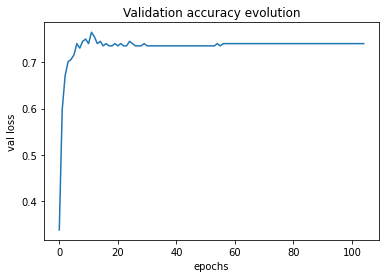

In [ ]:
plt.figure()
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Validation accuracy evolution')
plt.xlabel('epochs')
plt.ylabel('val loss')

We can see that the validation accuracy was increasing (with some noise) and converged around epoch 40

Let us continue training with more data (no validation split).

In [ ]:
early_stopping_callback=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
history = model.fit(X_train, y_train_, batch_size=100, epochs=100, callbacks=early_stopping_callback)

Epoch 1/100
14/14 [==============================] - 0s 18ms/step - loss: 0.3133 - categorical_accuracy: 0.9441
Epoch 2/100
14/14 [==============================] - 0s 27ms/step - loss: 0.0979 - categorical_accuracy: 0.9691
Epoch 3/100
14/14 [==============================] - 0s 15ms/step - loss: 0.0404 - categorical_accuracy: 0.9846
Epoch 4/100
14/14 [==============================] - 0s 15ms/step - loss: 0.0130 - categorical_accuracy: 0.9993
Epoch 5/100
14/14 [==============================] - 0s 13ms/step - loss: 0.0051 - categorical_accuracy: 1.0000
Epoch 6/100
14/14 [==============================] - 0s 19ms/step - loss: 0.0026 - categorical_accuracy: 1.0000
Epoch 7/100
14/14 [==============================] - 0s 20ms/step - loss: 0.0020 - categorical_accuracy: 1.0000
Epoch 8/100
14/14 [==============================] - 0s 18ms/step - loss: 0.0017 - categorical_accuracy: 1.0000
Epoch 9/100
14/14 [==============================] - 0s 14ms/step - loss: 0.0015 - categorical_accuracy:

**Generalization accuracy**

In [ ]:
_, score_nn = model.evaluate(X_test, pd.get_dummies(y_test))
score_nn

11/11 [==============================] - 0s 4ms/step - loss: 1.6003 - categorical_accuracy: 0.7971


0.7970588207244873

In [ ]:
m_table = pd.DataFrame(index=['Arbre', 'Linear SVC', 'Poly SVC', 'RBF SVC', 'KNN', 'Random Forest', 'Logistic Reg.', 'Neural Network'])
m_table['Gen. Score'] = [score_tree, score_linear_svm, score_poly_svm, score_rbf_svm, score_knn, score_rf, score_logi, score_nn]
m_table['Gen. Score'] = m_table['Gen. Score'].apply(lambda row: "{:.2%}".format(row))
m_table

,Gen. Score
Arbre,56.47%
Linear SVC,72.94%
Poly SVC,77.94%
RBF SVC,81.47%
KNN,75.59%
Random Forest,78.24%
Logistic Reg.,82.94%
Neural Network,79.71%


The neural network did not performs as well as many of the previous models. At the end of the next section we will try Convolutional Neural Network which are more adapted to images classification problems.

# Part 3 : using HOG representation

Let's preprocess our datato use HOG representation

In [ ]:
from skimage.feature import hog

def my_hog(row, ori, cell):
    return(pd.Series(hog(row.to_numpy().reshape(32, 32, 1), orientations=ori, pixels_per_cell=(cell, cell), cells_per_block=(1,1))))

We have made some parameters tuning to select the values of orientation and cell block that seemed to give us the best and better accuracy only the RBF SVC.

Check it out on this link: https://colab.research.google.com/drive/1aUe1bqgVxpL2CBFrXvV-S2Py67VZNL38?usp=sharing

Best found values are used below.

In [ ]:
orientation = 8
cell = 4

hog_train = X_train.apply(my_hog, axis=1, args=(orientation, cell))
hog_test = X_test.apply(my_hog, axis=1, args=(orientation, cell))

In [ ]:
hog_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
952,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.707107,0.0,0.707107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Decision trees

We use randomized CV trying randomly 100 pruning values with the purpose to locate which values of ccp_alpha are most likely to produce good accuracy.

In [ ]:
tree_model = DecisionTreeClassifier(random_state=21)
path = tree_model.cost_complexity_pruning_path(hog_train, y_train)
print(f"{len(path.ccp_alphas)} different trees can be obtained")

# Construct grid cv to select best params
grid = {"ccp_alpha": path.ccp_alphas} 
model = DecisionTreeClassifier(random_state=21)
grid_tree = RandomizedSearchCV(model, grid, cv=5, verbose=1, n_iter=100)
grid_tree.fit(hog_train, y_train)

# Print selected params
print("Tuned hpyerparameters (best parameters): ", grid_tree.best_params_)
print("Accuracy :", grid_tree.best_score_)

220 different trees can be obtained
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tuned hpyerparameters (best parameters):  {'ccp_alpha': 0.0011029411764705882}
Accuracy : 0.6588235294117648


Accuracy evolution with params

In [ ]:
p_table = pd.DataFrame(grid_tree.cv_results_).loc[:, ['param_ccp_alpha', 'mean_test_score']]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76]),
 <a list of 77 Text major ticklabel objects>)

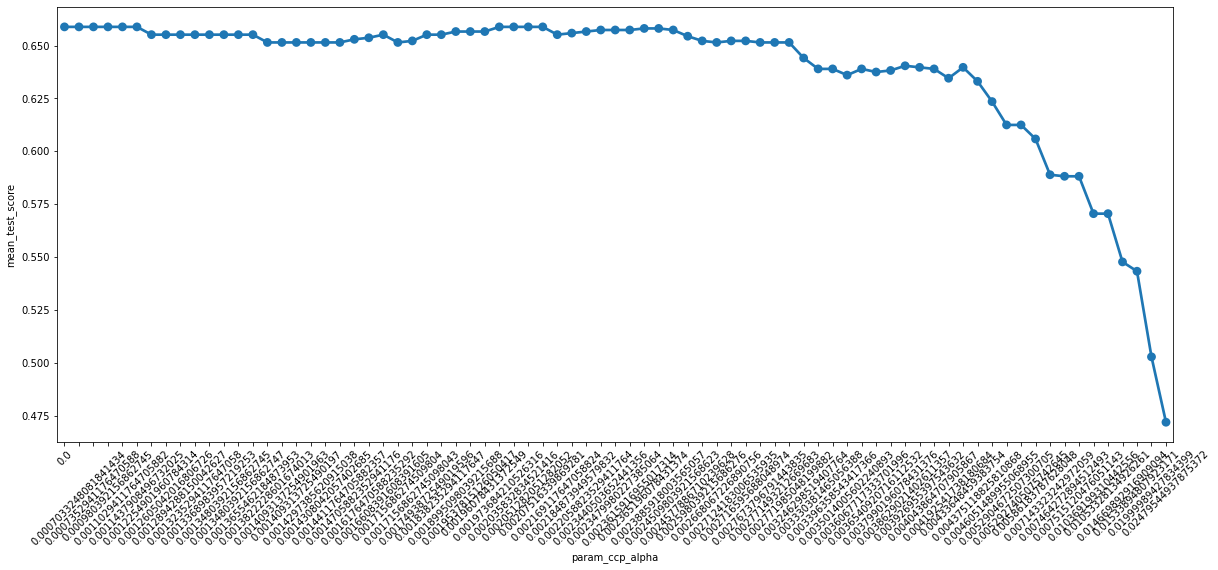

In [ ]:
plt.figure(figsize=(20, 8))
# .loc[(p_table['param_ccp_alpha'] < 0.0037) & (p_table['param_ccp_alpha'] > 0.0015)]
sns.pointplot(data=p_table, x='param_ccp_alpha', y='mean_test_score')
plt.xticks(rotation=45)

We can visually see that the model performs better for ccp_alpha values below 0.0028. Let's make grid search using those values then.

In [ ]:
ccp_alphas = path.ccp_alphas[np.where((path.ccp_alphas < 0.0028))]

In [ ]:
# Construct grid cv to select best params
grid = {"ccp_alpha": ccp_alphas} 
model = DecisionTreeClassifier(random_state=21)
grid_tree = GridSearchCV(model, grid, cv=3, verbose=1)
grid_tree.fit(hog_train, y_train)

# Print selected params
print("Tuned hpyerparameters (best parameters): ", grid_tree.best_params_)
print("Accuracy :", grid_tree.best_score_)

Fitting 3 folds for each of 163 candidates, totalling 489 fits
Tuned hpyerparameters (best parameters):  {'ccp_alpha': 0.0011029411764705882}
Accuracy : 0.6345735559639928


Params table

In [ ]:
p_table = pd.DataFrame(grid_tree.cv_results_).loc[:, ['param_ccp_alpha', 'mean_test_score']]
p_table.head()

,param_ccp_alpha,mean_test_score
0,0.0,0.631633
1,0.000703,0.631633
2,0.000723,0.631633
3,0.000726,0.631633
4,0.000727,0.631633


**Generalization accuracy**

In [ ]:
score_tree_hog = model_accuracy(grid_tree, hog_test, y_test)

Accuracy for our testing dataset with tuning is : 68.24%


The decision tree's accuracy is higher than with raw values (56% of accuracy)

### SVM

#### Linear SVM

In [ ]:
# Search for best params using GridSearchCV

grid_params = {'C': [0.01, 0.05, 0.1, 1, 10], 'kernel': ['linear']}
model = SVC(random_state=1)
grid_linear_svm = GridSearchCV(model, grid_params, refit=True, verbose=5, cv=3)
grid_linear_svm.fit(hog_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END .............C=0.01, kernel=linear;, score=0.793 total time=   0.2s
[CV 2/3] END .............C=0.01, kernel=linear;, score=0.806 total time=   0.2s
[CV 3/3] END .............C=0.01, kernel=linear;, score=0.815 total time=   0.2s
[CV 1/3] END .............C=0.05, kernel=linear;, score=0.852 total time=   0.2s
[CV 2/3] END .............C=0.05, kernel=linear;, score=0.839 total time=   0.2s
[CV 3/3] END .............C=0.05, kernel=linear;, score=0.859 total time=   0.2s
[CV 1/3] END ..............C=0.1, kernel=linear;, score=0.857 total time=   0.2s
[CV 2/3] END ..............C=0.1, kernel=linear;, score=0.854 total time=   0.2s
[CV 3/3] END ..............C=0.1, kernel=linear;, score=0.859 total time=   0.2s
[CV 1/3] END ................C=1, kernel=linear;, score=0.846 total time=   0.1s
[CV 2/3] END ................C=1, kernel=linear;, score=0.834 total time=   0.2s
[CV 3/3] END ................C=1, kernel=linear;,

GridSearchCV(cv=3, estimator=SVC(random_state=1),
             param_grid={'C': [0.01, 0.05, 0.1, 1, 10], 'kernel': ['linear']},
             verbose=5)

In [ ]:
print("Tuned hyperparameters (best parameters): ", grid_linear_svm.best_params_) 
print("Accuracy: ", grid_linear_svm.best_score_ * 100)

Tuned hyperparameters (best parameters):  {'C': 0.1, 'kernel': 'linear'}
Accuracy:  85.66174921311017


In [ ]:
score_linear_svm_hog = model_accuracy(grid_linear_svm, hog_test, y_test)

Accuracy for our testing dataset with tuning is : 86.76%


Params comparison

In [ ]:
p_table = pd.DataFrame(grid_linear_svm.cv_results_).loc[:, ['params', 'mean_test_score']]
p_table

,params,mean_test_score
0,"{'C': 0.01, 'kernel': 'linear'}",0.804420
1,"{'C': 0.05, 'kernel': 'linear'}",0.849998
2,"{'C': 0.1, 'kernel': 'linear'}",0.856617
3,"{'C': 1, 'kernel': 'linear'}",0.842645
4,"{'C': 10, 'kernel': 'linear'}",0.833085


Models comparison

In [ ]:
m_table = pd.DataFrame(index=['Decision Tree', 'Linear SVC'])
m_table['Gen. Score'] = [score_tree_hog, score_linear_svm_hog]
m_table

,Gen. Score
Decision Tree,0.682353
Linear SVC,0.867647


Like with the raw values, Linear SVC performs better than the decision tree and we already have less than 15% of error.

#### Poly & RBF SVM

As we tune the same parameters for Poly and RBF kernels we choose to consider the kernel as a parameter to be tuned as well, and we will select the most performing model using our usual and well-known by now GridSearchCV.

In [ ]:
# Search for best parameters (for both poly and RBF SVM) using GridSearchCV

grid_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['poly', 'rbf']}
model = SVC(random_state=1)
grid_svm = GridSearchCV(model, grid_params, refit=True, verbose=2, cv=5)
grid_svm.fit(hog_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ......................C=0.001, gamma=1, kernel=poly; total time=   0.3s
[CV] END ......................C=0.001, gamma=1, kernel=poly; total time=   0.2s
[CV] END ......................C=0.001, gamma=1, kernel=poly; total time=   0.3s
[CV] END ......................C=0.001, gamma=1, kernel=poly; total time=   0.3s
[CV] END ......................C=0.001, gamma=1, kernel=poly; total time=   0.3s
[CV] END .......................C=0.001, gamma=1, kernel=rbf; total time=   0.6s
[CV] END .......................C=0.001, gamma=1, kernel=rbf; total time=   1.2s
[CV] END .......................C=0.001, gamma=1, kernel=rbf; total time=   0.7s
[CV] END .......................C=0.001, gamma=1, kernel=rbf; total time=   0.6s
[CV] END .......................C=0.001, gamma=1, kernel=rbf; total time=   0.6s
[CV] END ....................C=0.001, gamma=0.1, kernel=poly; total time=   0.4s
[CV] END ....................C=0.001, gamma=0.1

GridSearchCV(cv=5, estimator=SVC(random_state=1),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['poly', 'rbf']},
             verbose=2)

In [ ]:
print("Tuned hyperparameters (best parameters): ", grid_svm.best_params_) 
print("Accuracy: ", grid_svm.best_score_ * 100)

Tuned hyperparameters (best parameters):  {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Accuracy:  91.83823529411764


Params comparison table

In [ ]:
p_table = pd.DataFrame(grid_svm.cv_results_).loc[:, ['params', 'mean_test_score']]
p_table

,params,mean_test_score
0,"{'C': 0.001, 'gamma': 1, 'kernel': 'poly'}",0.902206
1,"{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}",0.153676
2,"{'C': 0.001, 'gamma': 0.1, 'kernel': 'poly'}",0.153676
3,"{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}",0.153676
4,"{'C': 0.001, 'gamma': 0.01, 'kernel': 'poly'}",0.153676
5,"{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}",0.153676
6,"{'C': 0.001, 'gamma': 0.001, 'kernel': 'poly'}",0.153676
7,"{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}",0.153676
8,"{'C': 0.01, 'gamma': 1, 'kernel': 'poly'}",0.906618
9,"{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}",0.153676


In [ ]:
score_svm_hog = model_accuracy(grid_svm, hog_test, y_test)

Accuracy for our testing dataset with tuning is : 92.65%


Models comparison

In [ ]:
m_table = pd.DataFrame(index=['Arbre', 'Linear SVC', 'RBF SVC'])
m_table['Gen. Score'] = [score_tree_hog, score_linear_svm_hog, score_svm_hog]
m_table

,Gen. Score
Arbre,0.682353
Linear SVC,0.867647
RBF SVC,0.926471


RBF is definitely one of the best types of models for this classification problem and HOG representation helps have better accuracy.

### K-nearest-neighbour

In [ ]:
# Search for best k param using GridSearchCV

grid_params = {"n_neighbors": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 30, 50, 100, 200]} 
model = KNeighborsClassifier()
grid_knn = GridSearchCV(model, grid_params, refit=True, verbose=0, cv=5)
grid_knn.fit(hog_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 30, 50,
                                         100, 200]})

In [ ]:
print("Tuned hyperparameters (best parameters): ", grid_knn.best_params_) 
print("Accuracy: ", grid_knn.best_score_ * 100)

Tuned hyperparameters (best parameters):  {'n_neighbors': 7}
Accuracy:  85.44117647058825


Params comparison table

In [ ]:
p_table = pd.DataFrame(grid_knn.cv_results_).loc[:, ['params', 'mean_test_score']]
p_table

,params,mean_test_score
0,{'n_neighbors': 1},0.852941
1,{'n_neighbors': 2},0.825000
2,{'n_neighbors': 3},0.853676
3,{'n_neighbors': 4},0.850000
4,{'n_neighbors': 5},0.849265
5,{'n_neighbors': 6},0.851471
6,{'n_neighbors': 7},0.854412
7,{'n_neighbors': 8},0.854412
8,{'n_neighbors': 9},0.849265
9,{'n_neighbors': 10},0.849265


**Generalization accuracy**

In [ ]:
score_knn_hog = model_accuracy(grid_knn, hog_test, y_test)

Accuracy for our testing dataset with tuning is : 87.35%


Models comparison 

In [ ]:
m_table = pd.DataFrame(index=['Arbre', 'Linear SVC', 'RBF SVC', 'KNN'])
m_table['Gen. Score'] = [score_tree_hog, score_linear_svm_hog, score_svm_hog, score_knn_hog]
m_table

,Gen. Score
Arbre,0.682353
Linear SVC,0.867647
RBF SVC,0.926471
KNN,0.873529


RBF is still better

### Random forest

Let's randomly try some params

In [ ]:
# number of trees
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)]

# maximum depth of each tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] # 12
max_depth.append(None)

# 240 combinations possibles.
grid_params = {'n_estimators': n_estimators, 'max_depth': max_depth,}
model = RandomForestClassifier(random_state=0)
grid_rf = RandomizedSearchCV(model, grid_params, refit=True, verbose=2, cv=3, n_iter=10)
grid_rf.fit(hog_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END .....................max_depth=60, n_estimators=500; total time=   1.7s
[CV] END .....................max_depth=60, n_estimators=500; total time=   1.6s
[CV] END .....................max_depth=60, n_estimators=500; total time=   1.6s
[CV] END ....................max_depth=110, n_estimators=100; total time=   0.3s
[CV] END ....................max_depth=110, n_estimators=100; total time=   0.3s
[CV] END ....................max_depth=110, n_estimators=100; total time=   0.3s
[CV] END ....................max_depth=20, n_estimators=1000; total time=   3.2s
[CV] END ....................max_depth=20, n_estimators=1000; total time=   3.2s
[CV] END ....................max_depth=20, n_estimators=1000; total time=   3.2s
[CV] END ....................max_depth=20, n_estimators=2000; total time=  12.0s
[CV] END ....................max_depth=20, n_estimators=2000; total time=  14.2s
[CV] END ....................max_depth=20, n_est

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0),
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100, 1200,
                                                         1300, 1400, 1500, 1600,
                                                         1700, 1800, 1900,
                                                         2000]},
                   verbose=2)

In [ ]:
p_table = pd.DataFrame(grid_rf.cv_results_).loc[:, ['params', 'mean_test_score']]
p_table['params'] = p_table['params'].astype(str)

We plot the accuracy evolution with params, to visually catch some tendancy in order to restrain our params for GridSearchCV.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

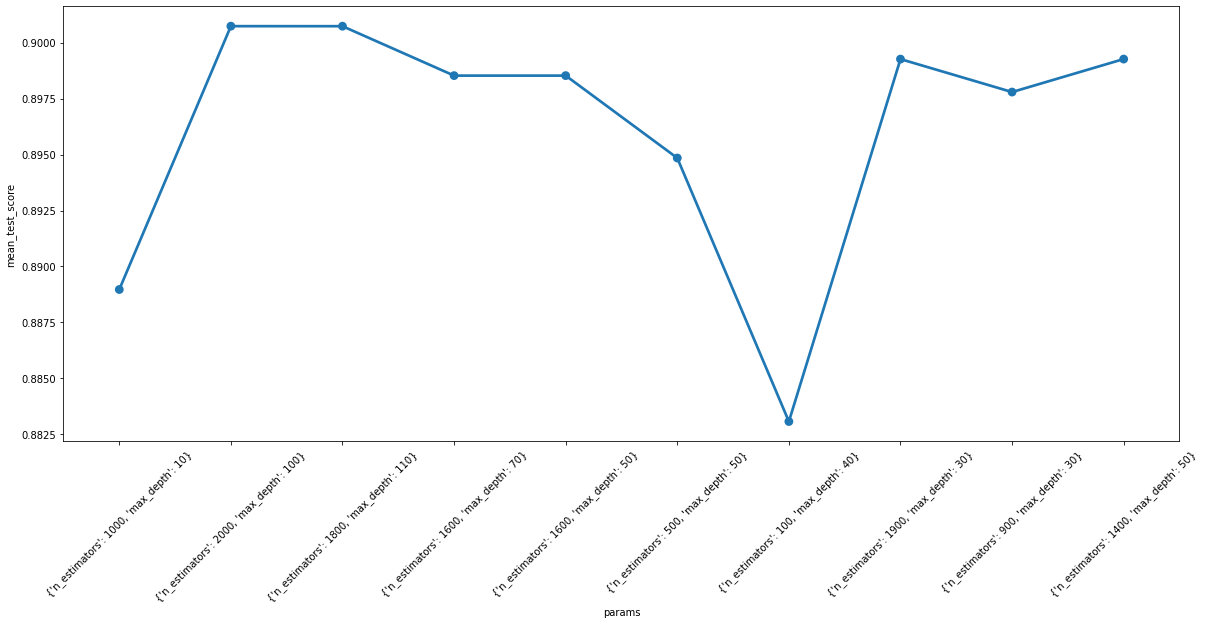

In [ ]:
plt.figure(figsize=(20, 8))
sns.pointplot(data=p_table, x='params', y='mean_test_score')
plt.xticks(rotation=45)

We restrain our search to the following one based on the results above: big number of estimators (2000 and more)

In [ ]:
grid_params = {'n_estimators': [2300, 2400, 2500, 2700, 2800], 'max_depth': [100, 200, None]}
grid_rf = GridSearchCV(model, grid_params, refit=True, verbose=2, cv=3)
grid_rf.fit(hog_train, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END ...................max_depth=100, n_estimators=2300; total time=   7.5s
[CV] END ...................max_depth=100, n_estimators=2300; total time=   7.4s
[CV] END ...................max_depth=100, n_estimators=2300; total time=   7.3s
[CV] END ...................max_depth=100, n_estimators=2400; total time=   7.6s
[CV] END ...................max_depth=100, n_estimators=2400; total time=   7.6s
[CV] END ...................max_depth=100, n_estimators=2400; total time=   7.7s
[CV] END ...................max_depth=100, n_estimators=2500; total time=   8.1s
[CV] END ...................max_depth=100, n_estimators=2500; total time=   8.0s
[CV] END ...................max_depth=100, n_estimators=2500; total time=   8.1s
[CV] END ...................max_depth=100, n_estimators=2700; total time=   8.6s
[CV] END ...................max_depth=100, n_estimators=2700; total time=   8.7s
[CV] END ...................max_depth=100, n_est

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [100, 200, None],
                         'n_estimators': [2300, 2400, 2500, 2700, 2800]},
             verbose=2)

In [ ]:
print("Tuned hyperparameters (best parameters): ", grid_rf.best_params_) 
print("Accuracy: ", grid_rf.best_score_ * 100)

Tuned hyperparameters (best parameters):  {'max_depth': 100, 'n_estimators': 2700}
Accuracy:  90.29426923787574


Params comparison

In [ ]:
p_table = pd.DataFrame(grid_rf.cv_results_).loc[:, ['params', 'mean_test_score']]
p_table

,params,mean_test_score
0,"{'max_depth': 100, 'n_estimators': 2300}",0.899999
1,"{'max_depth': 100, 'n_estimators': 2400}",0.901471
2,"{'max_depth': 100, 'n_estimators': 2500}",0.902207
3,"{'max_depth': 100, 'n_estimators': 2700}",0.902943
4,"{'max_depth': 100, 'n_estimators': 2800}",0.900737
5,"{'max_depth': 200, 'n_estimators': 2300}",0.899999
6,"{'max_depth': 200, 'n_estimators': 2400}",0.901471
7,"{'max_depth': 200, 'n_estimators': 2500}",0.902207
8,"{'max_depth': 200, 'n_estimators': 2700}",0.902943
9,"{'max_depth': 200, 'n_estimators': 2800}",0.900737


In [ ]:
score_rf_hog = model_accuracy(grid_rf, hog_test, y_test)

Accuracy for our testing dataset with tuning is : 91.76%


Models comparison

In [ ]:
m_table = pd.DataFrame(index=['Arbre', 'Linear SVC', 'RBF SVC', 'KNN', 'Random Forest'])
m_table['Gen. Score'] = [score_tree_hog, score_linear_svm_hog, score_svm_hog, score_knn_hog, score_rf_hog]
m_table

,Gen. Score
Arbre,0.682353
Linear SVC,0.867647
RBF SVC,0.926471
KNN,0.873529
Random Forest,0.917647


Random Forest is pratically as good as the RBF SVC model with the HOG representation data.

### Logistic regression

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

grid_params = {'poly__degree': np.arange(1, 3)}
poly = PolynomialFeatures()
model = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=0)
pipeline = Pipeline(steps=[('poly', poly), ('model', model)])

grid_logi = GridSearchCV(pipeline, grid_params, refit=True, verbose=2, cv=3)
grid_logi.fit(hog_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END .....................................poly__degree=1; total time=   1.5s
[CV] END .....................................poly__degree=1; total time=   1.2s
[CV] END .....................................poly__degree=1; total time=   0.6s
[CV] END .....................................poly__degree=2; total time= 2.3min
[CV] END .....................................poly__degree=2; total time= 2.4min
[CV] END .....................................poly__degree=2; total time= 2.2min


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('model',
                                        LogisticRegression(max_iter=1000,
                                                           multi_class='multinomial',
                                                           random_state=0))]),
             param_grid={'poly__degree': array([1, 2])}, verbose=2)

In [ ]:
print("Tuned hyperparameters (best parameters): ", grid_logi.best_params_) 
print("Accuracy: ", grid_logi.best_score_ * 100)

Tuned hyperparameters (best parameters):  {'poly__degree': 2}
Accuracy:  89.78015708622239


Params comparison

In [ ]:
p_table = pd.DataFrame(grid_logi.cv_results_).loc[:, ['params', 'mean_test_score']]
p_table

,params,mean_test_score
0,{'poly__degree': 1},0.849995
1,{'poly__degree': 2},0.897802


In [ ]:
score_logi_hog = model_accuracy(grid_logi, hog_test, y_test)

Accuracy for our testing dataset with tuning is : 90.88%


Models comparison

In [ ]:
m_table = pd.DataFrame(index=['Arbre', 'Linear SVC', 'RBF SVC', 'KNN', 'Random Forest', 'Logistic Reg.'])
m_table['Gen. Score'] = [0.68, 0.86, 0.93, 0.87, 0.92, 0.91]
m_table

,Gen. Score
Arbre,0.68
Linear SVC,0.86
RBF SVC,0.93
KNN,0.87
Random Forest,0.92
Logistic Reg.,0.91


RBF model is still the best with ~ 93% of accuracy.

### Neural networks

#### DNN

Preprocessing target variable with one hot encoding.

In [ ]:
y_train_ = pd.get_dummies(y_train)
y_train_.head()

,1,2,6,12,16,18,22
880,1,0,0,0,0,0,0
952,0,1,0,0,0,0,0
286,0,0,0,0,0,0,1
360,0,0,0,0,1,0,0
331,0,0,0,0,1,0,0


Getting labels of each column for submission purpose

In [ ]:
labels = y_train_.columns
labels

Int64Index([1, 2, 6, 12, 16, 18, 22], dtype='int64')

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(512,)),         
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(40, activation='relu'),
  tf.keras.layers.Dense(20, activation='relu'),
  tf.keras.layers.Dense(7),
  tf.keras.layers.Activation('softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                32832     
                                                                 
 dense_5 (Dense)             (None, 40)                2600      
                                                                 
 dense_6 (Dense)             (None, 20)                820       
                                                                 
 dense_7 (Dense)             (None, 7)                 147       
                                                                 
 activation_1 (Activation)   (None, 7)                 0         
                                                                 
Total params: 36,399
Trainable params: 36,399
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
history = model.fit(hog_train, y_train_, validation_split=0.15, batch_size=30, epochs=1000, callbacks=early_stopping)

Epoch 1/1000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


39/39 [==============================] - 1s 11ms/step - loss: 1.7652 - categorical_accuracy: 0.3235 - val_loss: 1.4776 - val_categorical_accuracy: 0.6373
Epoch 2/1000
23/39 [================>.............] - ETA: 0s - loss: 1.2197 - categorical_accuracy: 0.7058

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


39/39 [==============================] - 0s 3ms/step - loss: 1.0757 - categorical_accuracy: 0.7310 - val_loss: 0.7650 - val_categorical_accuracy: 0.7990
Epoch 3/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.6022 - categorical_accuracy: 0.8304 - val_loss: 0.5410 - val_categorical_accuracy: 0.8480
Epoch 4/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.4198 - categorical_accuracy: 0.8737 - val_loss: 0.4667 - val_categorical_accuracy: 0.8676
Epoch 5/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.3275 - categorical_accuracy: 0.9005 - val_loss: 0.4593 - val_categorical_accuracy: 0.8676
Epoch 6/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.2658 - categorical_accuracy: 0.9247 - val_loss: 0.4588 - val_categorical_accuracy: 0.8529
Epoch 7/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.2135 - categorical_accuracy: 0.9455 - val_loss: 0.4458 - val_categorical_accuracy: 0.8627
Epoch 8/1000
39/3

Let's see how evolved validation accuracy with training epochs

Text(0, 0.5, 'Accuracy')

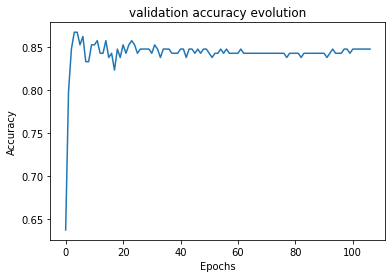

In [ ]:
plt.figure()
plt.plot(history.history['val_categorical_accuracy'])
plt.title('validation accuracy evolution')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Same for the loss

Text(0, 0.5, 'Loss')

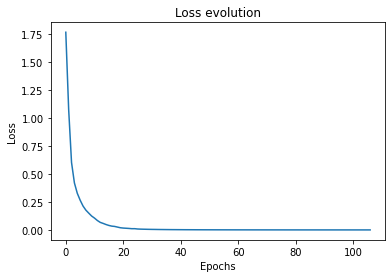

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.title('Loss evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')

Generalization score of the neural network model

In [ ]:
_, score_nn_hog = model.evaluate(hog_test, pd.get_dummies(y_test))
score_nn_hog

11/11 [==============================] - 0s 2ms/step - loss: 0.7328 - categorical_accuracy: 0.8471


0.8470588326454163

Models comparison

In [ ]:
m_table = pd.DataFrame(index=['Arbre', 'Linear SVC', 'RBF SVC', 'KNN', 'Random Forest', 'Logistic Reg.', 'Neural Network'])
m_table['Gen. Score'] = [0.68, 0.86, 0.93, 0.87, 0.92, 0.91, 0.85]
m_table

,Gen. Score
Arbre,0.68
Linear SVC,0.86
RBF SVC,0.93
KNN,0.87
Random Forest,0.92
Logistic Reg.,0.91
Neural Network,0.85


#### CNN

In this section we will try a Convulational Neural Network. This type of model is well-known to gives best accuracy for images classification as they can capture and learn way more differents features in images.

**Preprocessing**

In [ ]:
def reshape(X):
  """Reshape variables for convolutional layer input."""
  return X.values.astype('float32').reshape([-1, 32, 32, 1]) # image size is 32x32

In [ ]:
X_train_ = reshape(X_train)
X_test_ = reshape(X_test)

y_train_ = pd.get_dummies(y_train)
y_test_ = pd.get_dummies(y_test)

In [ ]:
X_train_.shape

(1360, 32, 32, 1)

In [ ]:
y_train_.shape

(1360, 7)

We define a function to create and compile a CNN model. We choose to tune 3 hyper-parameters.

*   Optimizer
*   Initializer
*   Activation

We have some Dropout to prevent the models from overfitting.

In [ ]:

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, Dropout, Dense, Flatten

def create_model(optimizer='adam', kernel_initializer='he_normal', activation='relu'):
  # Create model
  model = Sequential()
  model.add(Conv2D(filters=8, kernel_size=3, input_shape=(32, 32, 1), kernel_initializer=kernel_initializer, activation=activation))
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(0.3))

  model.add(Conv2D(filters=12, kernel_size=3, kernel_initializer=kernel_initializer, activation=activation))
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=16, kernel_size=3, kernel_initializer=kernel_initializer, activation=activation))
  model.add(AveragePooling2D())

  model.add(Flatten())

  model.add(Dense(80, activation=activation))
  model.add(Dense(32, activation=activation))
  model.add(Dense(7, activation='softmax'))

  # Compile model
  model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer=optimizer)
  return model

In [ ]:
model = create_model()
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 30, 30, 8)         80        
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 15, 15, 8)        0         
 g2D)                                                            
                                                                 
 dropout_26 (Dropout)        (None, 15, 15, 8)         0         
                                                                 
 conv2d_40 (Conv2D)          (None, 13, 13, 12)        876       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 6, 6, 12)         0         
 g2D)                                                            
                                                                 
 dropout_27 (Dropout)        (None, 6, 6, 12)        

We have 10723 weights to train.

In [ ]:
# Seed for reprocible output
np.random.seed(1)

# Possible choosen values
optimizer = ['RMSprop', 'Adam', 'SGD', 'Nadam']
kernel_initializer = ['normal', 'uniform']
activation = ['relu', 'sigmoid', 'tanh']

param_grid = dict(optimizer=optimizer, kernel_initializer=kernel_initializer, activation=activation)

# count number of different parameters values combinations
n = 1
for x in param_grid:
  n = n * len(param_grid[x]) 
print("Number of different parameter combinations = {}".format(n))

Number of different parameter combinations = 24


We train each model on 5 epochs and look for some insights into the results.

In [ ]:
# Creating the models with different hyperparameters
for o, k, a in [(x,y,z) for x in optimizer for z in activation for y in kernel_initializer]:
    params = {'optimizer' : o , 'kernel_initializer' : k , 'activation' : a}
    print(params)
    model_ = create_model(o, k, a)
    model_.fit(X_train_, y_train_, validation_split=0.15, epochs=5, batch_size=30, verbose=1)
    print("=============================================================================")

{'optimizer': 'RMSprop', 'kernel_initializer': 'normal', 'activation': 'relu'}
Epoch 1/5
39/39 [==============================] - 2s 23ms/step - loss: 1.7909 - categorical_accuracy: 0.2526 - val_loss: 1.4516 - val_categorical_accuracy: 0.4314
Epoch 2/5
39/39 [==============================] - 1s 18ms/step - loss: 1.2574 - categorical_accuracy: 0.5000 - val_loss: 1.0783 - val_categorical_accuracy: 0.4853
Epoch 3/5
39/39 [==============================] - 1s 18ms/step - loss: 0.9988 - categorical_accuracy: 0.6081 - val_loss: 0.9035 - val_categorical_accuracy: 0.6569
Epoch 4/5
39/39 [==============================] - 1s 18ms/step - loss: 0.8313 - categorical_accuracy: 0.6964 - val_loss: 0.8885 - val_categorical_accuracy: 0.6373
Epoch 5/5
39/39 [==============================] - 1s 18ms/step - loss: 0.7574 - categorical_accuracy: 0.7258 - val_loss: 0.7250 - val_categorical_accuracy: 0.7451
{'optimizer': 'RMSprop', 'kernel_initializer': 'uniform', 'activation': 'relu'}
Epoch 1/5
39/39 [====

We can that combinations below gave us more than 70% of accuracy after only 5 epochs:



*   'optimizer': 'RMSprop', 'kernel_initializer': 'normal', 'activation': 'relu'
*   'optimizer': 'Nadam', 'kernel_initializer': 'uniform', 'activation': 'tanh'
*   'optimizer': 'Nadam', 'kernel_initializer': 'normal', 'activation': 'relu'
*   'optimizer': 'Adam', 'kernel_initializer': 'normal', 'activation': 'relu'

Let us restrain our params values to these and train over more epochs, let us say 50.

In [ ]:
optimizer = ['RMSprop', 'Nadam', 'Adam']
kernel_initializer = ['uniform', 'normal']
activation = ['relu', 'tanh']

for o, k, a in [(x,y,z) for x in optimizer for z in activation for y in kernel_initializer]:
    params = {'optimizer' : o , 'kernel_initializer' : k , 'activation' : a}
    print(params)
    model_ = create_model(o, k, a)
    model_.fit(X_train_, y_train_, validation_split=0.15, epochs=25, batch_size=20, verbose=1)
    print("\n=============================================================================\n")

{'optimizer': 'RMSprop', 'kernel_initializer': 'uniform', 'activation': 'relu'}
Epoch 1/25
58/58 [==============================] - 3s 27ms/step - loss: 1.8062 - categorical_accuracy: 0.2561 - val_loss: 1.3958 - val_categorical_accuracy: 0.4559
Epoch 2/25
58/58 [==============================] - 1s 19ms/step - loss: 1.2117 - categorical_accuracy: 0.5199 - val_loss: 1.0376 - val_categorical_accuracy: 0.5588
Epoch 3/25
58/58 [==============================] - 1s 15ms/step - loss: 0.9666 - categorical_accuracy: 0.6237 - val_loss: 0.7892 - val_categorical_accuracy: 0.6912
Epoch 4/25
58/58 [==============================] - 1s 15ms/step - loss: 0.8466 - categorical_accuracy: 0.6756 - val_loss: 0.7269 - val_categorical_accuracy: 0.7255
Epoch 5/25
58/58 [==============================] - 1s 15ms/step - loss: 0.7516 - categorical_accuracy: 0.7059 - val_loss: 0.6862 - val_categorical_accuracy: 0.7108
Epoch 6/25
58/58 [==============================] - 1s 15ms/step - loss: 0.6684 - categorical_a

From the results above, we can see that the combination that seems to perform better is Adam, uniform, tanh with an accuracy of 92% over 25 epochs. Let's train that model.

In [ ]:
model = create_model(optimizer='Adam', kernel_initializer='uniform', activation='tanh')

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=20)
history = model.fit(X_train_, y_train_, validation_split=0.15, batch_size=20, epochs=500, callbacks=early_stopping)

Epoch 1/500
58/58 [==============================] - 3s 28ms/step - loss: 1.7845 - categorical_accuracy: 0.2405 - val_loss: 1.3256 - val_categorical_accuracy: 0.4755
Epoch 2/500
58/58 [==============================] - 2s 27ms/step - loss: 1.1407 - categorical_accuracy: 0.5718 - val_loss: 1.0012 - val_categorical_accuracy: 0.6422
Epoch 3/500
58/58 [==============================] - 2s 27ms/step - loss: 0.9247 - categorical_accuracy: 0.6652 - val_loss: 0.9033 - val_categorical_accuracy: 0.6618
Epoch 4/500
58/58 [==============================] - 1s 21ms/step - loss: 0.8491 - categorical_accuracy: 0.6946 - val_loss: 0.8262 - val_categorical_accuracy: 0.7010
Epoch 5/500
58/58 [==============================] - 1s 15ms/step - loss: 0.7605 - categorical_accuracy: 0.7284 - val_loss: 0.8042 - val_categorical_accuracy: 0.6863
Epoch 6/500
58/58 [==============================] - 1s 15ms/step - loss: 0.7045 - categorical_accuracy: 0.7535 - val_loss: 0.7502 - val_categorical_accuracy: 0.7304
Epoc

Plot of validation accuracy evolution

Text(0, 0.5, 'Accuracy')

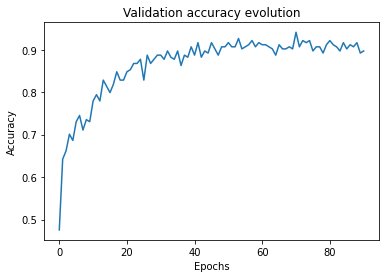

In [ ]:
plt.figure()
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Validation accuracy evolution')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Not totally converged yet. We continue training with large batch size

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='categorical_accuracy', patience=50)
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='weights__cnn.hdf5', monitor='loss', verbose=1, save_best_only=True)

history = model.fit(X_train_, y_train_, batch_size=100, epochs=100, callbacks=[early_stopping, checkpointer])

Epoch 1/100
14/14 [==============================] - ETA: 0s - loss: 0.0854 - categorical_accuracy: 0.9721
Epoch 1: loss improved from inf to 0.08539, saving model to weights__cnn.hdf5
14/14 [==============================] - 1s 49ms/step - loss: 0.0854 - categorical_accuracy: 0.9721
Epoch 2/100
14/14 [==============================] - ETA: 0s - loss: 0.0842 - categorical_accuracy: 0.9787
Epoch 2: loss improved from 0.08539 to 0.08420, saving model to weights__cnn.hdf5
14/14 [==============================] - 1s 48ms/step - loss: 0.0842 - categorical_accuracy: 0.9787
Epoch 3/100
13/14 [==========================>...] - ETA: 0s - loss: 0.0794 - categorical_accuracy: 0.9762
Epoch 3: loss improved from 0.08420 to 0.08146, saving model to weights__cnn.hdf5
14/14 [==============================] - 1s 51ms/step - loss: 0.0815 - categorical_accuracy: 0.9765
Epoch 4/100
14/14 [==============================] - ETA: 0s - loss: 0.0632 - categorical_accuracy: 0.9787
Epoch 4: loss improved from 0.

Text(0, 0.5, 'Accuracy')

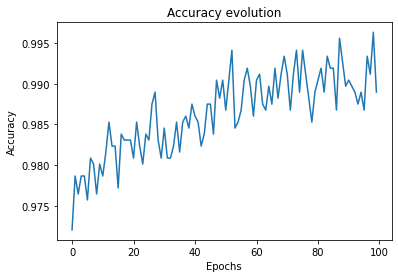

In [ ]:
plt.figure()
plt.plot(history.history['categorical_accuracy'])
plt.title('Accuracy evolution')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

We can see that more data improved the accuracy.

**Generalization accuracy**

In [ ]:
_, score_cnn = model.evaluate(X_test_, pd.get_dummies(y_test))
score_cnn

11/11 [==============================] - 0s 7ms/step - loss: 0.1821 - categorical_accuracy: 0.9382


0.9382352828979492

Models comparison

In [ ]:
m_table = pd.DataFrame(index=['Arbre', 'Linear SVC', 'RBF SVC', 'KNN', 'Random Forest', 'Logistic Reg.', 'DNN', 'CNN'])
m_table['Gen. Score'] = [0.68, 0.86, 0.93, 0.87, 0.92, 0.91, 0.85, 0.94]
m_table

,Gen. Score
Arbre,0.68
Linear SVC,0.86
RBF SVC,0.93
KNN,0.87
Random Forest,0.92
Logistic Reg.,0.91
DNN,0.85
CNN,0.94


CNN have now the best generalization accuracy with 94%

#### LeNet-5 & Data Augmentation

Now let us try a well-known CNN architecture for images classification called LeNet-5. We change the output layer to have 7 outputs matching our present classification problem outputs.

The experiment has been conducted on this other notebook for the sake of clarity as this one was getting really long.
Here is the link to it: https://colab.research.google.com/drive/12fFKn3ETeLBiyjON6JGl22dvbmaUgeNy?usp=sharing

The accuracy of the model with data augmentation reached **97.94%** and is therefore the best that we found overall.

# Submission

In [ ]:
X_competition = competition.copy()

**Preprocessing**

In [ ]:
# X_competition = reshape(X_competition)
# hog_competition = X_competition.apply(my_hog, axis=1, args=(orientation, cell))

In [ ]:
# Change model and submission title
model = model
submission_title = 'submission_cnn'

# Make predictions
pred = model.predict(X_competition)

# For Neural network only
idx_pred = np.argmax(pred, axis=1)
pred = [labels[idx] for idx in idx_pred]

# Export
df = pd.DataFrame(np.arange(1, 501), columns=['Id'])
df['label'] = pred
df.to_csv(f'{submission_title}.csv', index=False)